# Exercise 10.1

By adapting your Genetic Algorithm (GA) code, developed during the Numerical Exercise 9, write a C++ code to solve the TSP with a Simulated Annealing (SA) algorithm. Apply your code to the optimization of a path among 

- 32 cities randomly placed on a circumference
- 32 cities randomly placed inside a square

Show your results via:

- a picture of the length of the best path as a function of the iteration of your algorithm
- a picture of the best path

and compare your SA results with those obtained with GA in the previous numerical exercise.

I reduced the size of the population from 5000 individuals down to 500 because I prefer to do more iterations (slower decrease in temperature). The temperature decreases as a function of the number of MC steps:
$$
T' = \begin{cases} T - 2, & \mbox{if } T > 50 
\\ T - 0.5, & \mbox{if } 10 < T \leq 50
\\ T - 0.1, & \mbox{if } 1 < T \leq 10 
\\ T - 0.01, & \mbox{if } 0.1 < T \leq 1 
\\ T - 0.005, & \mbox{if } 0.01 < T \leq 0.1 
\\ T - 0.0000002, & \mbox{if } T \leq 0.01 \end{cases}
$$

In [46]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, log, exp
import math
import scipy
from scipy import constants
import subprocess
from mpl_toolkits.mplot3d import Axes3D as ax

sourceDirectory = 'TSP/'
squareDirectory = 'SQ/'
circleDirectory = 'CI/'

titleSize = 20
axesLabelSize = 15

directories = [squareDirectory, circleDirectory]
distribution = ['Box', 'Circle']
shapes = ['_BOX_', '_CIRCLE_']
algorithm = ['_SA_', '_GA_']

In [47]:
def run_simulation(directory, shape, algo):
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define .*.$/#define '+str(shape)+'/ if $. == 4" '+sourceDirectory+'city.h'])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define .*.$/#define '+str(algo)+'/ if $. == 6" '+sourceDirectory+'city.h'])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; make clean"])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; make"])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; ./T_S_P.exe"])

    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"path_average.txt "+directory+"path_average_"+str(algo)+".txt"])
    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"best_configuration.txt "+directory+"best_configuration_"+str(algo)+".txt"])
    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"best_distance.txt "+directory+"best_distance_"+str(algo)+".txt"])

def plot_simulations(directory, dist, algo):
    plt.figure(figsize=(12, 12))
    plt.title('Best configuration ('+str(dist)+')', fontsize=titleSize)
    for al in algo:
        x = []
        y = []
        with open(directory+'/best_configuration_'+str(al)+'.txt', 'r') as reader:
            for line in reader:
                data = line.split()
                x.append(float(data[0]))
                y.append(float(data[1]))
        plt.plot(x, y, 'o-', label='Best configuration ('+str(al)+')')
    
    plt.legend(loc='best')
    plt.xlabel('$x$', fontsize=axesLabelSize)
    plt.ylabel('$y$', fontsize=axesLabelSize)
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.title('Best configuration ('+str(dist)+')', fontsize=titleSize)
    for al in range(len(algo)):
        plt.subplot(121 + al)
        path = []
        bestPath = []
        count = 0
        with open(directory+'/path_average_'+str(algo[al])+'.txt', 'r') as reader:
            for line in reader:
                data = line.split()
                path.append(float(data[0]))
                bestPath.append(float(data[1]))
                count += 1
        
        n = np.arange(count)
        plt.plot(n, path, label='Average Distance of the best half of the population ('+str(algo[al])+')')
        plt.plot(n, bestPath, label='Best Distance ('+str(algo[al])+')')
        plt.grid(True)
        plt.legend(loc='best')
        plt.xlabel('#steps', fontsize=axesLabelSize)
        plt.ylabel('$D\{x_i\}$', fontsize=axesLabelSize)
    plt.show()

    for al in algo:
        with open(directory+'/best_distance_'+str(al)+'.txt', 'r') as reader:
            for line in reader:
                bestDistance = float(line)
        print('Best distance ('+str(al)+'):', bestDistance)

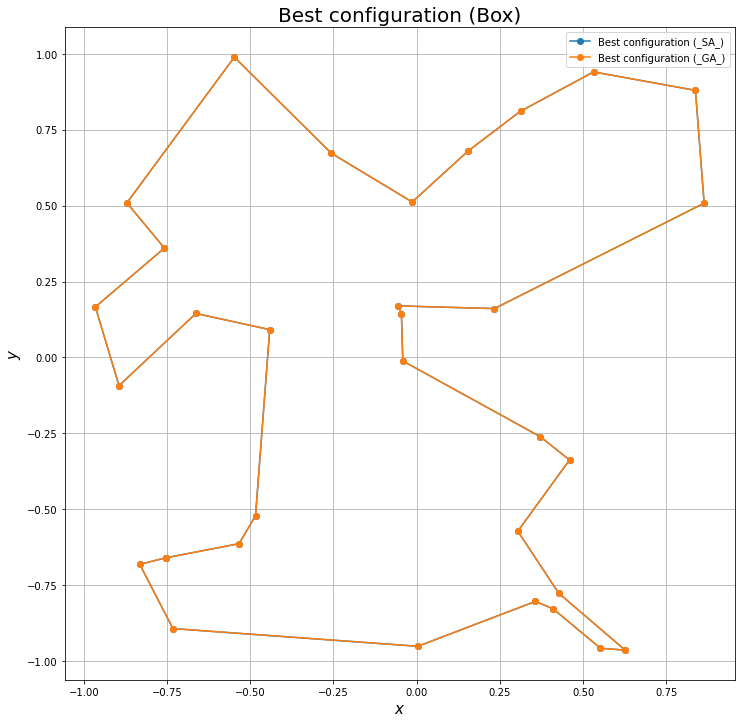

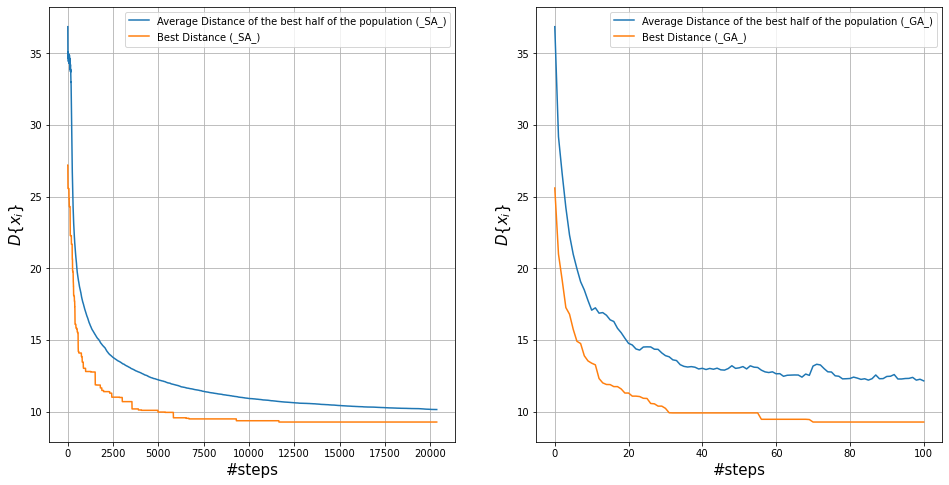

Best distance (_SA_): 9.27331
Best distance (_GA_): 9.27331


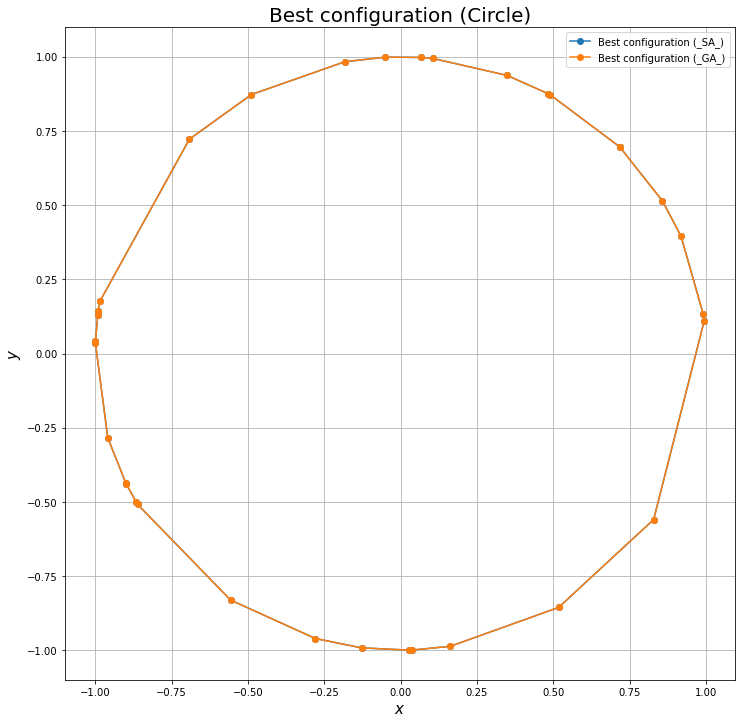

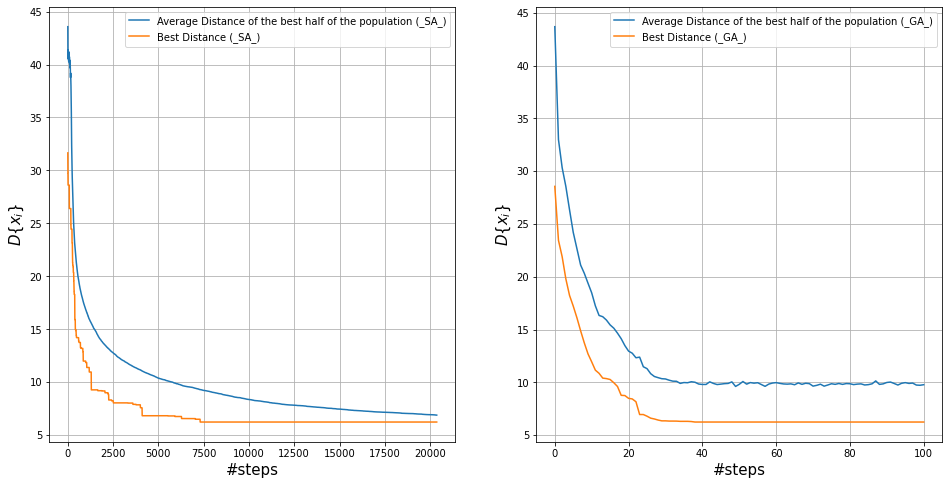

Best distance (_SA_): 6.2403
Best distance (_GA_): 6.2403


In [48]:
for i in range(len(directories)):
    for algo in algorithm:
        run_simulation(directories[i], shapes[i], algo)

for i in range(len(directories)):
    plot_simulations(directories[i], distribution[i], algorithm)

As we can see, the results obtained with the simulated annealing are identical to the ones obtained with the genetic algorithm. The cooling process is very slow, so there is a high chance that we have found the absolute minimum with both algorithms.

# Exercise 10.2

Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a Genetic Search with 4 parallel GA searches of the optimal path:
each node should perform an independent GA search the so-called Continents, but every $N_{migr}$ generations the Continents should exchange their best individuals randomly.
Apply your code to the TSP problem for 32 cities randomly placed inside a square and try to estimate if your performances improve with Continents.

I set $N_{migr}$ to $10$.

In [49]:
def run_parallel_simulation(directory, shape, algo, nCont):
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define .*.$/#define '+str(shape)+'/ if $. == 4" '+sourceDirectory+'city.h'])
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define .*.$/#define '+str(algo)+'/ if $. == 6" '+sourceDirectory+'city.h'])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; make clean"])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; make"])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; mpiexec -np "+str(nCont)+" T_S_P.exe"])

    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"path_average.txt "+directory+"path_average_"+str(nCont)+".txt"])
    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"best_configuration.txt "+directory+"best_configuration_"+str(nCont)+".txt"])
    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"best_distance.txt "+directory+"best_distance_"+str(nCont)+".txt"])    
    
def plot_parallel_simulations(directory, dist, algo, nCont):    
    plt.figure(figsize=(12, 12))
    for n in range(1,nCont):
        x = []
        y = []
        plt.subplot(200+int((nCont-1)/2)*10+n)
        plt.title('Best configuration ('+str(dist)+' '+str(n)+' continents)', fontsize=axesLabelSize)
        with open(directory+'best_configuration_'+str(n)+'.txt', 'r') as reader:
            for line in reader:
                data = line.split()
                x.append(float(data[0]))
                y.append(float(data[1]))
                
        plt.plot(x, y, 'o-', label='Best configuration ('+str(n)+')')
    
        plt.legend(loc='best')
        plt.xlabel('$x$', fontsize=axesLabelSize)
        plt.ylabel('$y$', fontsize=axesLabelSize)
        plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.title('Average Distance of the best half of the population ('+str(dist)+')', fontsize=titleSize)
    for n in range(1,nCont):
        path = []
        bestPath = []
        count = 0
        with open(directory+'path_average_'+str(n)+'.txt', 'r') as reader:
            for line in reader:
                data = line.split()
                path.append(float(data[0]))
                bestPath.append(float(data[1]))
                count += 1
        
        m = np.arange(count)
        plt.plot(m, path, label=str(n)+' continents')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('#steps', fontsize=axesLabelSize)
    plt.ylabel('$D\{x_i\}$', fontsize=axesLabelSize)
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.title('Best Distance ('+str(dist)+')', fontsize=titleSize)
    for n in range(1,nCont):
        path = []
        bestPath = []
        count = 0
        with open(directory+'path_average_'+str(n)+'.txt', 'r') as reader:
            for line in reader:
                data = line.split()
                path.append(float(data[0]))
                bestPath.append(float(data[1]))
                count += 1
        m = np.arange(count)
        plt.plot(m, bestPath, label=str(n)+' continents')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('#steps', fontsize=axesLabelSize)
    plt.ylabel('$D\{x_i\}$', fontsize=axesLabelSize)
    plt.show()

    for n in range(1,nCont):
        with open(directory+'best_distance_'+str(n)+'.txt', 'r') as reader:
            for line in reader:
                bestDistance = float(line)
        print('Best distance ('+str(n)+' continents):', bestDistance)

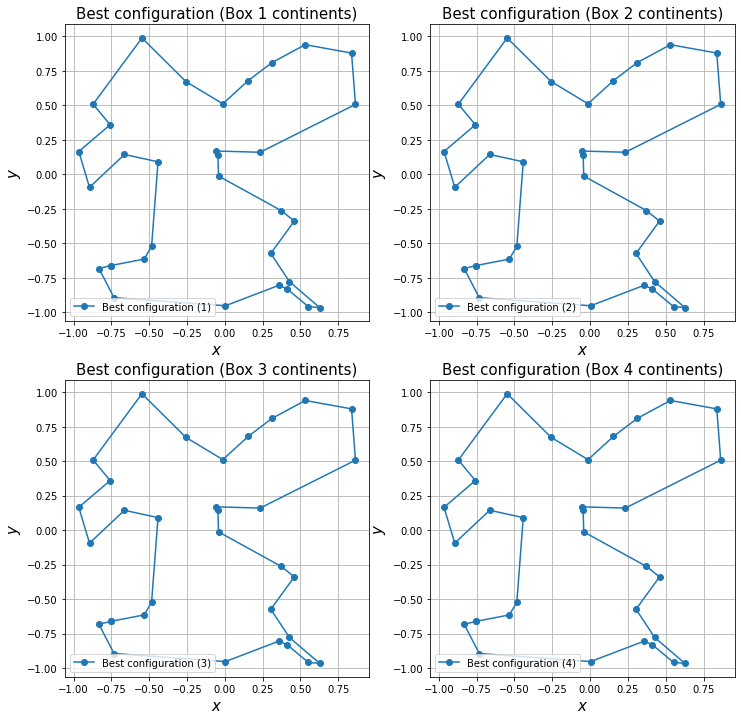

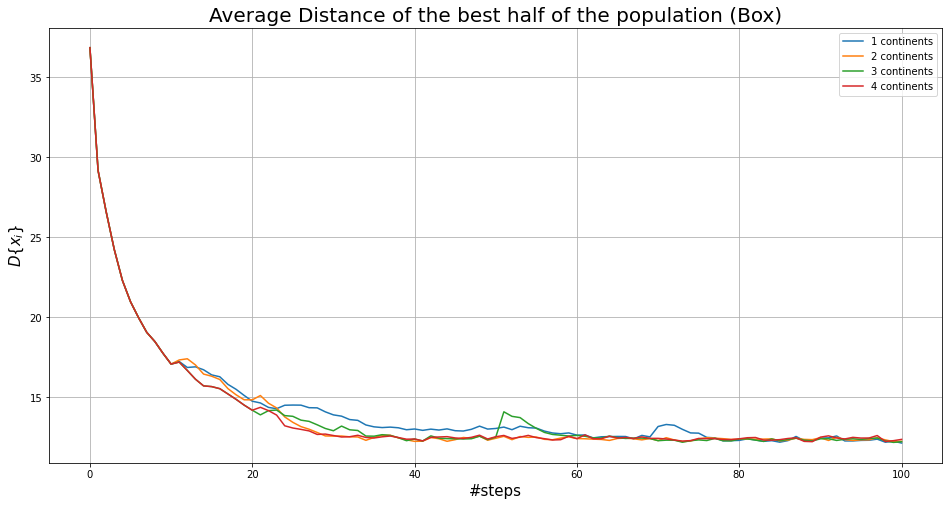

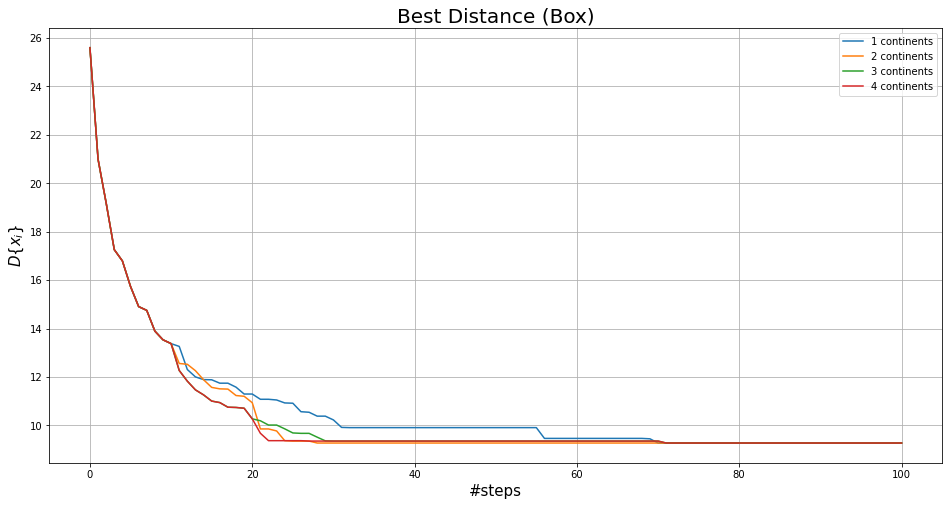

Best distance (1 continents): 9.27331
Best distance (2 continents): 9.27331
Best distance (3 continents): 9.27331
Best distance (4 continents): 9.27331


In [50]:
parallelDirectory = []
newDirectory = 'PA/'
maximumNumberOfContinents = 4

for i in range(1, maximumNumberOfContinents + 1):
    run_parallel_simulation(newDirectory, shapes[0], algorithm[1], i)

plot_parallel_simulations(newDirectory, distribution[0], algorithm[1], maximumNumberOfContinents + 1)

We can see that as the number of continents increases the algorithm converges faster.